In [2]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Loading Data and Preprocessing

#### 1. Loading Data

In [3]:
def load_data(file_url):
    with open('dataset.txt','wb') as f:
        content=requests.get(file_url,stream=True).content
        f.write(content)
    features,target=datasets.load_svmlight_file("dataset.txt")
    return features.toarray(),np.array(target)

In [4]:
## cleaned =https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
columns=['Pregnancies','Glucose','Blood Pressure','Skin Thickness','Insulin','BMI','Diabetes Pedigree','Age']
X,y=load_data('https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes')


#### 2. EDA

In [5]:
## Size of the data
print(X.shape,y.shape)

(768, 8) (768,)


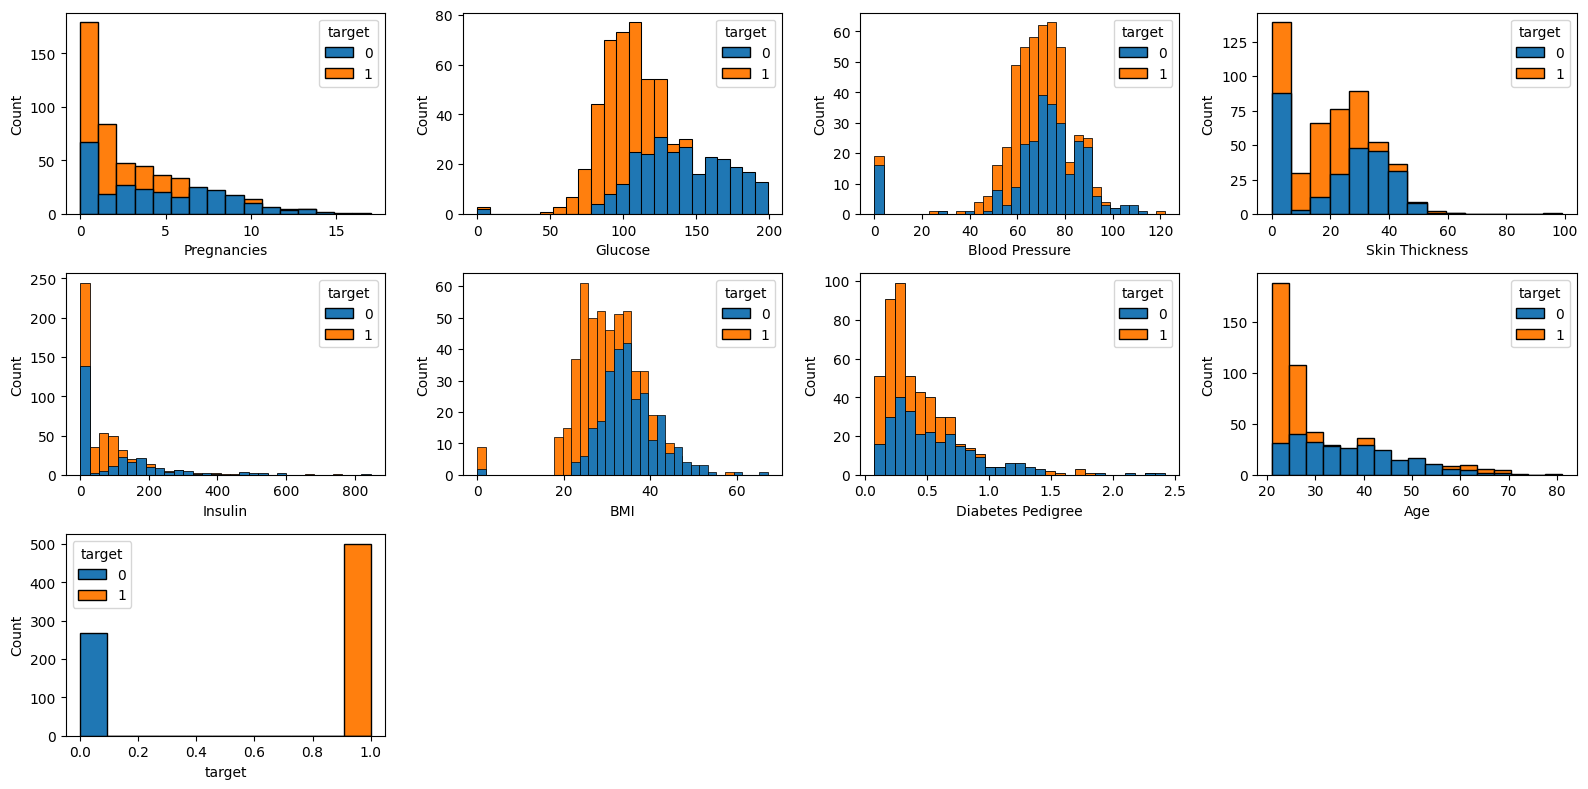

In [6]:
## general plotting of data based on the class to observe the distribution of the data.
df=pd.DataFrame(X,columns=columns)
df['target']=(y>0).astype(int)
fig,ax=plt.subplots(int(np.ceil(len(df.columns)/4)),4,figsize=(16,8))
for i in range(len(df.columns)):
    sns.histplot(data=df,x=df.columns[i],ax=ax[i//4,i%4],hue='target',alpha=1)

if((len(df.columns)%4)):
    for axes in ax.flatten()[(len(df.columns)%4)-4:]:
        fig.delaxes(axes)
plt.tight_layout()
plt.show()

In [7]:
## distribution of labels
df['target'].value_counts()

target
1    500
0    268
Name: count, dtype: int64

#### 3. Preprocessing

In [8]:
## checking for nas or nulls, others are included in the model class.
df.isna().sum()

Pregnancies          0
Glucose              0
Blood Pressure       0
Skin Thickness       0
Insulin              0
BMI                  0
Diabetes Pedigree    0
Age                  0
target               0
dtype: int64

## Base Model

In [9]:
a=np.array([0.25,1.25,-0.6,1.11,0.86,-1.5])
np.clip(a,0,1).round()

array([0., 1., 0., 1., 1., 0.])

In [10]:
class Perceptron:

    def __init__(self,X,y,split_ratio=[0.7,0.15,0.15],scaling=False,scaler=sklearn.preprocessing.MinMaxScaler,scale_range=(0,1)):
        self._X,self._y=X,y
        self._y=(self._y>0).astype(int)
        self.split(split_ratio)
        if(scaling):
            self.scale(scaler,scale_range)
        self._weights=np.zeros(len(self._X[0]))
        self._bias=0

        
    
    def split(self,split_ratio):
        
        self._X_train,X_rem,self._y_train,y_rem=train_test_split(self._X,self._y,train_size=split_ratio[0],stratify=self._y)
        self._X_val,self._X_test,self._y_val,self._y_test=train_test_split(X_rem,y_rem,train_size=split_ratio[1]/(split_ratio[1]+split_ratio[2]),stratify=y_rem)
        print('Splitted Data into Train,Val,Test with ratios:',split_ratio)
        print(np.array(self._X_train).shape,np.array(self._X_val).shape,np.array(self._X_test).shape,np.array(self._y_train).shape,np.array(self._y_val).shape,np.array(self._y_test).shape)
        
    def scale(self,scaler,scale_range):
        if(scaler==sklearn.preprocessing.StandardScaler):
            scaler_name=scaler.__name__
            scaler=scaler()
        if(scaler==sklearn.preprocessing.MinMaxScaler):
            scaler_name=scaler.__name__
            scaler=scaler(feature_range=scale_range)
        np.random.seed(42)
        self._X_train=scaler.fit_transform(self._X_train)
        self._X_val=scaler.transform(self._X_val)
        self._X_test=scaler.transform(self._X_test)
        print('Scaled data in range '+str(round(min(self._X_train.flatten()),4))+" , "+str(round(max(self._X_train.flatten()),4))+' using '+str(scaler_name))
    
    

    def sigmoid(self,x):
        
        return (1/(1+np.exp(-x)))
    
    def predict(self,input,act=None,mode=2):
        ## mode 1 will not change the pred valuyes, mode 2 will change the values to 0,1 appropriately so that it can be used for accuracy and f1
        pred=self._bias+np.sum(self._weights*input,axis=1)
        
        if(act==None):
            if (mode==1) :
                return (pred)
            elif(mode==2):
                #print(pred)
                return np.clip(pred,0,1).round()
        elif(act.lower()=='sigmoid'):
            if (mode==1):
                return self.sigmoid(self._bias+np.sum(self._weights*input,axis=1))
            elif(mode==2):
                return  np.round(0.5*(self.sigmoid(self._bias+np.sum(self._weights*input,axis=1))+1))
    
    def accuracy(self,true,pred):
        
        return round(sklearn.metrics.accuracy_score(true,pred),4)
    
    def f1(self,true,pred):
        
        return round(sklearn.metrics.f1_score(true,pred),4)
    
    def plot(self):
        fig,(ax0,ax1)=plt.subplots(1,2,figsize=(20,5))
        ax0.plot(range(self._epochs),self._train_accuracy,label='train')
        ax0.plot(range(self._epochs),self._val_accuracy,label='valid')
        ax1.plot(range(self._epochs),np.abs(self._train_loss),label='train loss')
        ax1.plot(range(self._epochs),np.abs(self._val_loss),label='val loss')
        ax0.legend()
        ax1.legend()
        plt.show()
    
    def lr_scheduler(self,lr,i,deacy_rate=0.001,decay_epoch=0):
        if(i>=decay_epoch):
            return lr/(1+(deacy_rate*(i-decay_epoch)))
        return lr
    
    def loss(self,act,preds):
        return np.sum(np.array(preds)-np.array(act))
    
    def train(self,epochs=20,batch_size=4,lr=1,decay=0,decay_epoch=0,activation=None,info=False,plot=False,early_stop=False):
        self._epochs=epochs
        self._train_accuracy=[]
        self._val_accuracy=[]
        self._train_loss=[]
        self._val_loss=[]
        self._act=activation
        for i in range(epochs):
            lr=self.lr_scheduler(lr,i,decay,decay_epoch)
            if(lr==0):
                self._epochs=i
                break
            index_list=list(range(0,len(self._X_train),batch_size))+[len(self._X_train)]
            train_loss=[]
            for j in range(len(index_list)-1):
                preds=self.predict(self._X_train[index_list[j]:index_list[j+1],:],mode=1,act=self._act) 
                error=self.loss(self._y_train[index_list[j]:index_list[j+1]],preds)
                train_loss.append(error)
                self._bias-=lr*error
                self._weights-=np.sum(lr*error*self._X_train[index_list[j]:index_list[j+1],:],axis=0)
            
            preds=self.predict(self._X_train,act=self._act)
            val_preds=self.predict(self._X_val,act=self._act)
            self._train_accuracy.append(self.accuracy(self._y_train,preds))
            self._val_accuracy.append(self.accuracy(self._y_val,val_preds))
            self._train_loss.append(np.sum(train_loss))
            self._val_loss.append(self.loss(self._y_val,val_preds))
            if(info):
                print('epoch '+str(i) +' train accuracy:'+str(self._train_accuracy[i])+", validation accuracy:  "+str(self._val_accuracy[i]))
                print('f1 scores: ',self.f1(self._y_train,preds),self.f1(self._y_val,val_preds))
            if(early_stop and i>20):
                if(self._train_accuracy[-1]<np.mean(self._train_accuracy[-10:-1])):
                    self._epochs=i+1
                    break
        if(plot):
            self.plot()

    def train_val(self):
        train_preds=self.predict(self._X_train,act=self._act)
        val_preds=self.predict(self._X_val,act=self._act)
        print('train accuracy:',self.accuracy(self._y_train,train_preds),',train f1score:',self.f1(self._y_train,train_preds))
        print('val accuracy:',self.accuracy(self._y_val,val_preds),',val f1score:',self.f1(self._y_val,val_preds))

    def test(self):
        test_preds=self.predict(self._X_test,act=self._act)
        print('test accuracy:',self.accuracy(self._y_test,test_preds),',test f1score:',self.f1(self._y_test,test_preds))
  


Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range 0.0 , 1.0 using MinMaxScaler
epoch 0 train accuracy:0.3464, validation accuracy:  0.3478
f1 scores:  0.0057 0.0
epoch 1 train accuracy:0.3464, validation accuracy:  0.3478
f1 scores:  0.0057 0.0
epoch 2 train accuracy:0.3464, validation accuracy:  0.3478
f1 scores:  0.0057 0.0
epoch 3 train accuracy:0.3464, validation accuracy:  0.3478
f1 scores:  0.0057 0.0
epoch 4 train accuracy:0.3464, validation accuracy:  0.3478
f1 scores:  0.0057 0.0
epoch 5 train accuracy:0.3464, validation accuracy:  0.3478
f1 scores:  0.0057 0.0
epoch 6 train accuracy:0.3464, validation accuracy:  0.3478
f1 scores:  0.0057 0.0
epoch 7 train accuracy:0.3464, validation accuracy:  0.3478
f1 scores:  0.0057 0.0
epoch 8 train accuracy:0.3464, validation accuracy:  0.3478
f1 scores:  0.0057 0.0
epoch 9 train accuracy:0.3464, validation accuracy:  0.3478
f1 scores:  0.0057 0.0
epoch 1

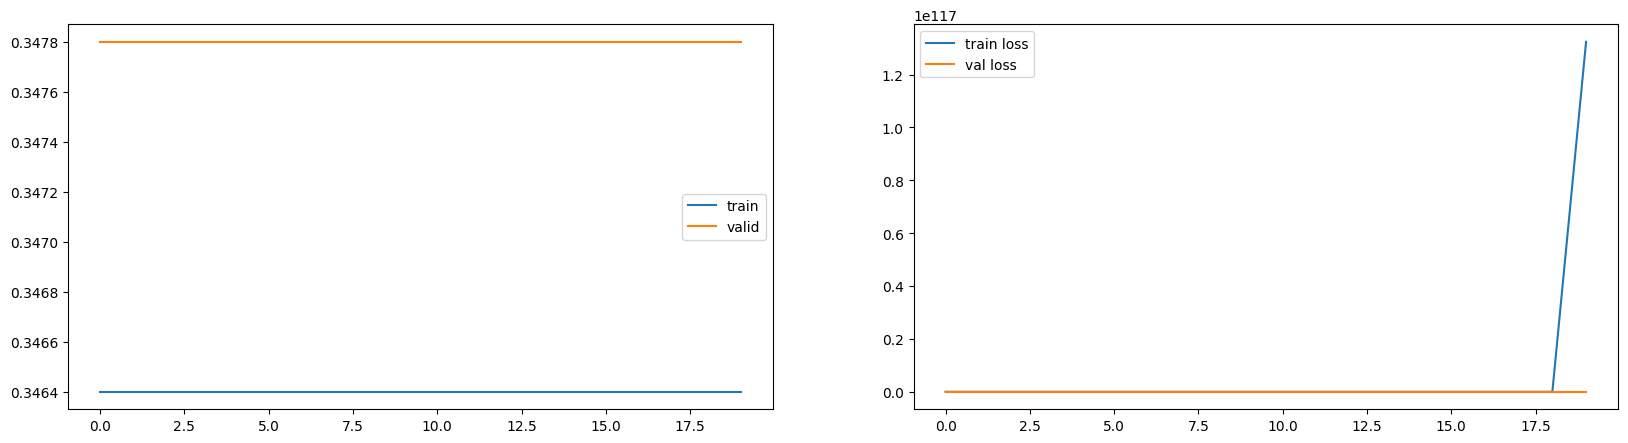

train accuracy: 0.3464 ,train f1score: 0.0057
val accuracy: 0.3478 ,val f1score: 0.0


In [440]:
## Base Model
## we would definetely need scaling as scaling features, as the model converges faster 
## putting learning rate as 0.1 as we need optimal rate so that the gradient descent doesn't miss the global min of the loss
perceptron=Perceptron(X,y,scaling=True)
perceptron.train(lr=0.1,info=True,plot=True)
perceptron.train_val()


## Experimental Analysis - I 
*Manual selection of parameters in a evolution kind of way, by looking at loss curves and others.*

Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range 0.0 , 1.0 using MinMaxScaler


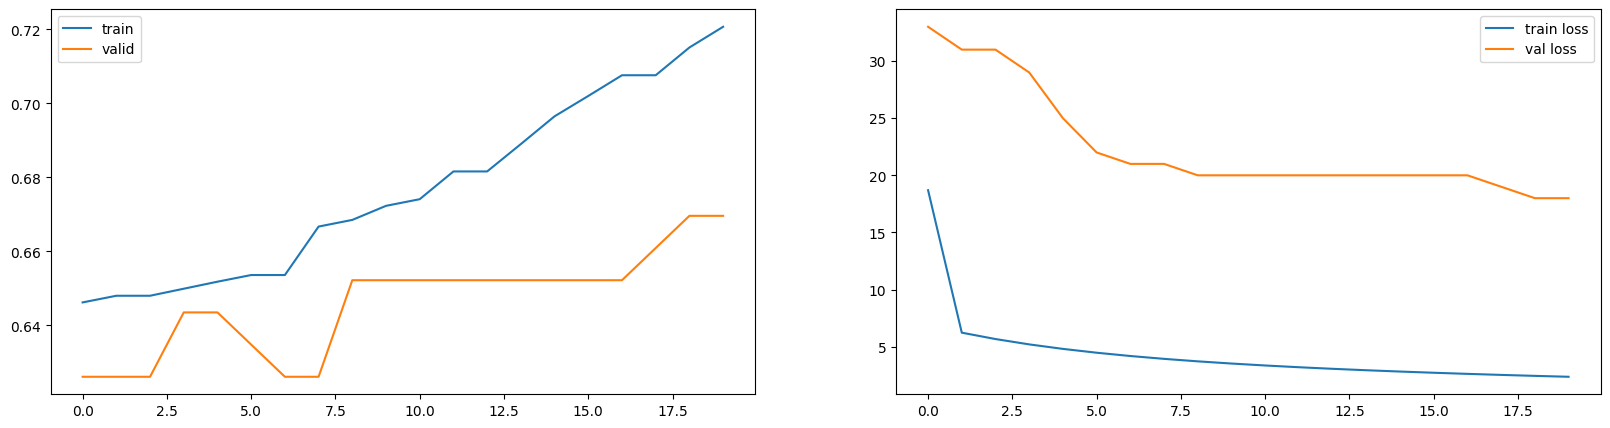

train accuracy: 0.7207 ,train f1score: 0.8125
val accuracy: 0.6696 ,val f1score: 0.7738


In [441]:
## the loss is huge, we need to reduce learning rate more to see if we can get better loss and accuracy
perceptron=Perceptron(X,y,scaling=True)
perceptron.train(lr=0.01,plot=True)
perceptron.train_val()

Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


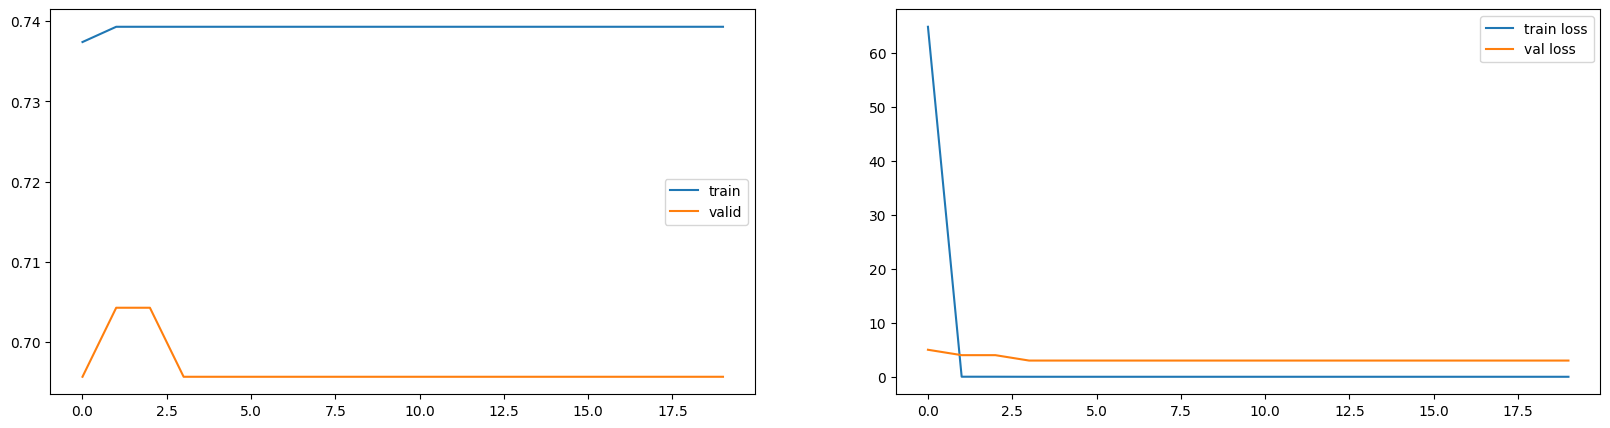

train accuracy: 0.7393 ,train f1score: 0.8066
val accuracy: 0.6957 ,val f1score: 0.7712


In [442]:
## the loss is better, let's test with standard scaler
perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
perceptron.train(lr=0.01,plot=True)
perceptron.train_val()

Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


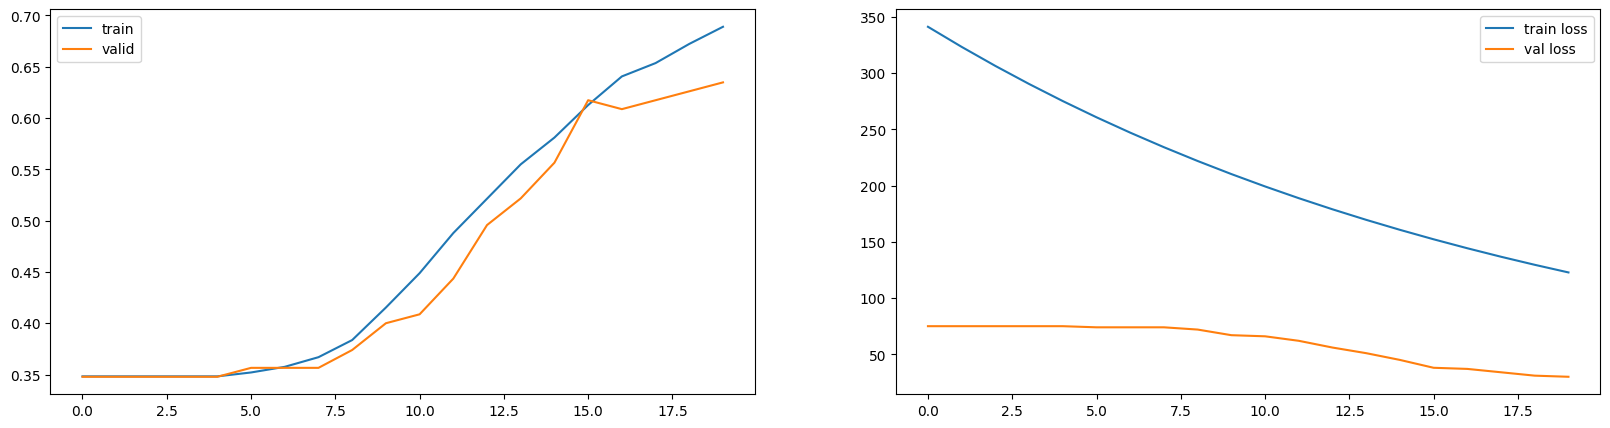

train accuracy: 0.689 ,train f1score: 0.7044
val accuracy: 0.6348 ,val f1score: 0.65


In [443]:
## the val is not improving much, let's reduce the learning rate more.
perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
perceptron.train(lr=0.0001,plot=True)
perceptron.train_val()

Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


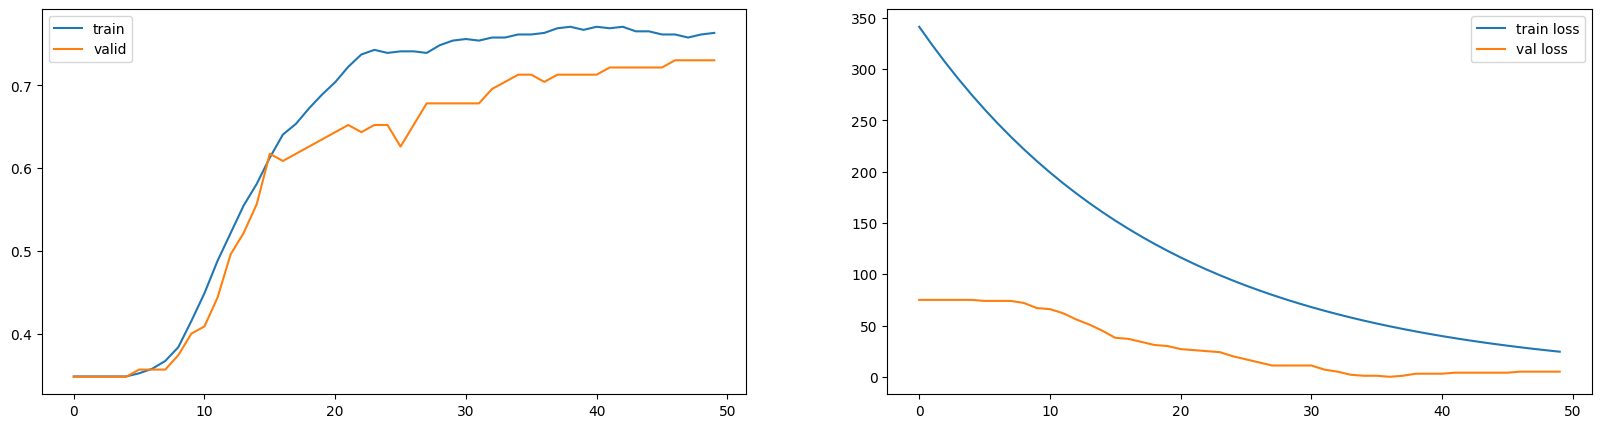

train accuracy: 0.7635 ,train f1score: 0.8248
val accuracy: 0.7304 ,val f1score: 0.8


In [444]:
## better, but I think it needs more epochs to converge as we have reduced the learning rate
perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
perceptron.train(lr=0.0001,plot=True,epochs=50)
perceptron.train_val()

Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


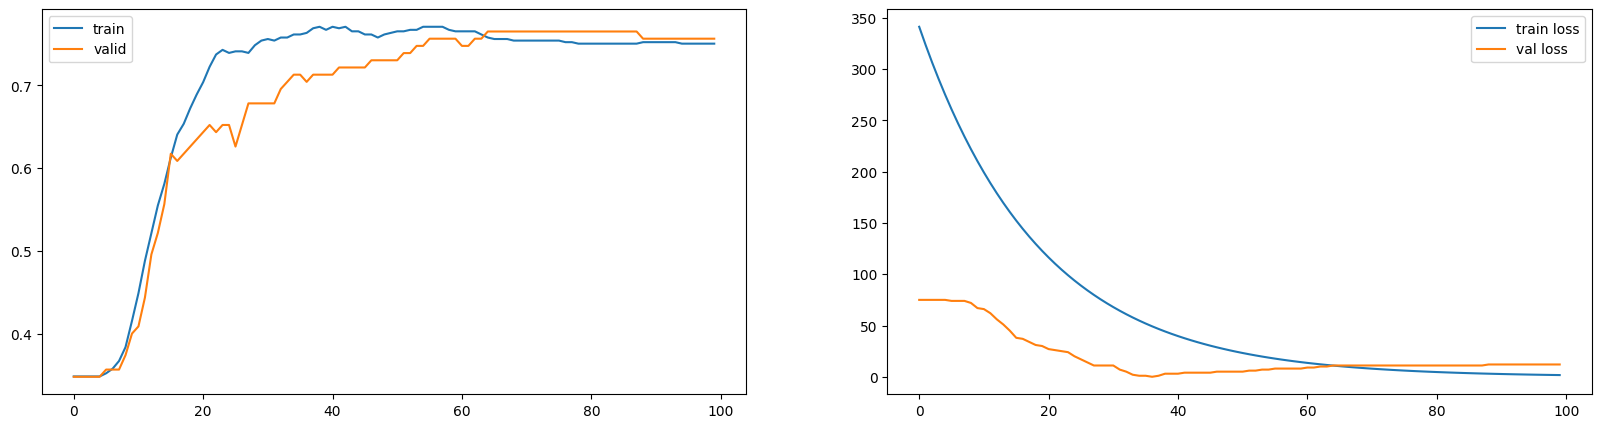

train accuracy: 0.7505 ,train f1score: 0.8199
val accuracy: 0.7565 ,val f1score: 0.8272


In [445]:
## as we can see that train hasn't converged fully, we need more epochs
perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
perceptron.train(lr=0.0001,plot=True,epochs=100)
perceptron.train_val()

Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


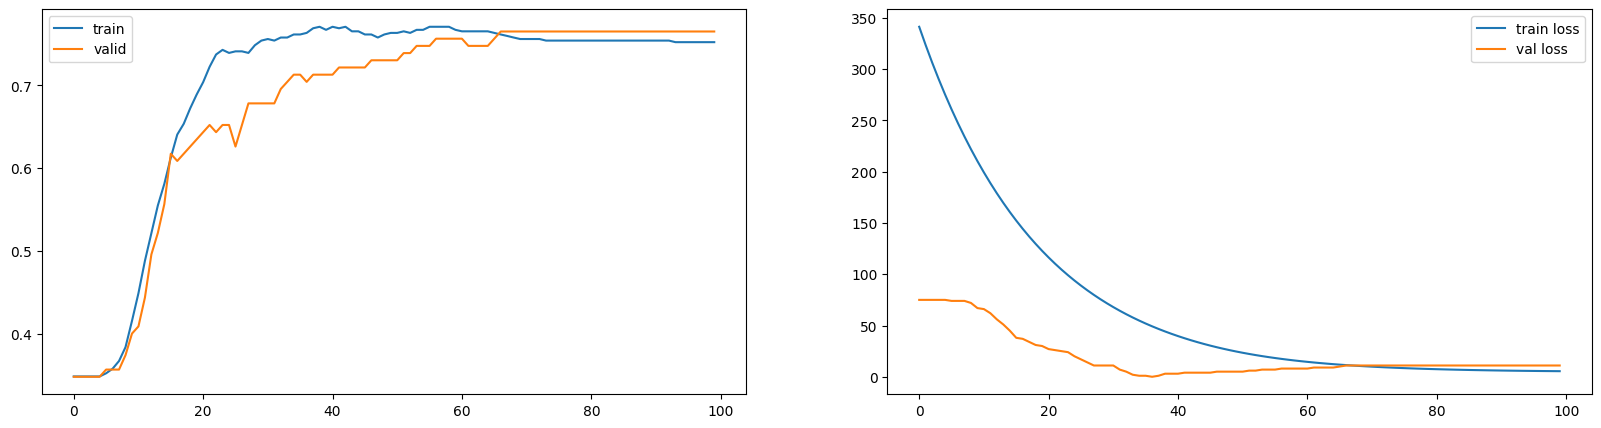

train accuracy: 0.7523 ,train f1score: 0.821
val accuracy: 0.7652 ,val f1score: 0.8323


In [474]:
## we can see after 40 epochs the val loss starts increasing, lets start learning rate decay after 40 epochs at 0.001,
# since we need decay to be there but small as well, so that training continues.
perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
perceptron.train(lr=0.0001,plot=True,epochs=100,decay=0.001,decay_epoch=40)
perceptron.train_val()

Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


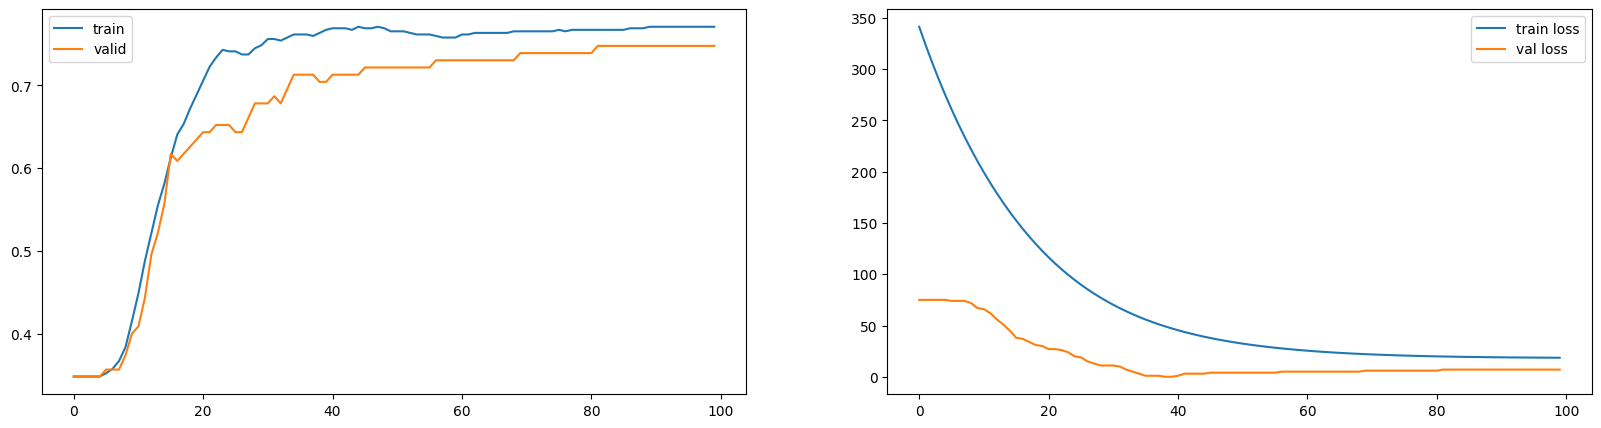

train accuracy: 0.7709 ,train f1score: 0.8317
val accuracy: 0.7478 ,val f1score: 0.8153


In [20]:
## we can see still see val loss starts increasing, lets start learning rate decay after 15 epochs
# since we need decay to be there but small as well, so that training continues.
perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
perceptron.train(lr=0.0001,plot=True,epochs=100,decay=0.001,decay_epoch=15)
perceptron.train_val()
## this is final model, even though the val performance is lesser, it is better since the above one is overfitting

**From the above evolutional test, best model parameters are:**
* scaling: True
* scaler: Standard Scaler
* epochs=100
* lr=0.0001
* decay=0.001
* decay epoch=20

with 74.78% of val accuracy and 81.53% of f1 score

## Experimental Analysis - II 
*chose to not to with grid search as for this assignmnet we are graded on how we are selecting hyperparameters and their values*

*grid search kind of hyperparameter tuning by testing with selected hyperparamter values*

In [447]:
## starting with lesser lr values as for higher value the model has ver large losses and gives error.
## we are not going be testing if to use scaling or not, for the same reason as above

##Test for scaler

for scaler in [sklearn.preprocessing.StandardScaler,sklearn.preprocessing.MinMaxScaler]:
    print('using:',scaler.__name__)
    perceptron=Perceptron(X,y,scaling=True,scaler=scaler,scale_range=(0,1 ))
    perceptron.train(lr=0.01)
    perceptron.train_val()
    print()

## Standardscaler is giving better val results

using: StandardScaler
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7393 ,train f1score: 0.8066
val accuracy: 0.6957 ,val f1score: 0.7712

using: MinMaxScaler
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range 0.0 , 1.0 using MinMaxScaler
train accuracy: 0.7207 ,train f1score: 0.8125
val accuracy: 0.6696 ,val f1score: 0.7738



In [448]:
##Test for split ratio
## Some of the ratios that I usually use
for split in [[0.7,0.15,0.15],[0.7,0.2,0.1],[0.8,0.1,0.1]]:
    print('using:',split)
    perceptron=Perceptron(X,y,scaling=True,split_ratio=split,scaler=sklearn.preprocessing.StandardScaler)
    perceptron.train(lr=0.01)
    perceptron.train_val()
    print()
## going with 0.7,0.15,0.15 as I would prefer the val and test sets being equal size when the val performance in similair

using: [0.7, 0.15, 0.15]
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7393 ,train f1score: 0.8066
val accuracy: 0.6957 ,val f1score: 0.7712

using: [0.7, 0.2, 0.1]
Splitted Data into Train,Val,Test with ratios: [0.7, 0.2, 0.1]
(537, 8) (154, 8) (77, 8) (537,) (154,) (77,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7393 ,train f1score: 0.8066
val accuracy: 0.7013 ,val f1score: 0.7767

using: [0.8, 0.1, 0.1]
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7394 ,train f1score: 0.8015
val accuracy: 0.6753 ,val f1score: 0.7664



In [449]:
##Test for activation function

for act in [None,'sigmoid']:
    print('using:',act)
    perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
    perceptron.train(activation=act,lr=0.01)
    perceptron.train_val()
    print()
## Not using any actiavtion functions as I can better results when activation fucntions is not used

using: None
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7393 ,train f1score: 0.8066
val accuracy: 0.6957 ,val f1score: 0.7712

using: sigmoid
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.6518 ,train f1score: 0.7892
val accuracy: 0.6522 ,val f1score: 0.7895



In [450]:
##Test for epochs
## Since this is a simpler model mroe epochs might not be that useful
for epochs in [25,50,100]:
    print('using:',epochs)
    perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
    perceptron.train(epochs=epochs,lr=0.01)
    perceptron.train_val()
    print()
## all epochs yield similair result thus choosing the epochs when testing with the final model and looking at the grpahs

using: 25
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7393 ,train f1score: 0.8066
val accuracy: 0.6957 ,val f1score: 0.7712

using: 50
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7393 ,train f1score: 0.8066
val accuracy: 0.6957 ,val f1score: 0.7712

using: 100
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7393 ,train f1score: 0.8066
val accuracy: 0.6957 ,val f1score: 0.7712



using: 0.01
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


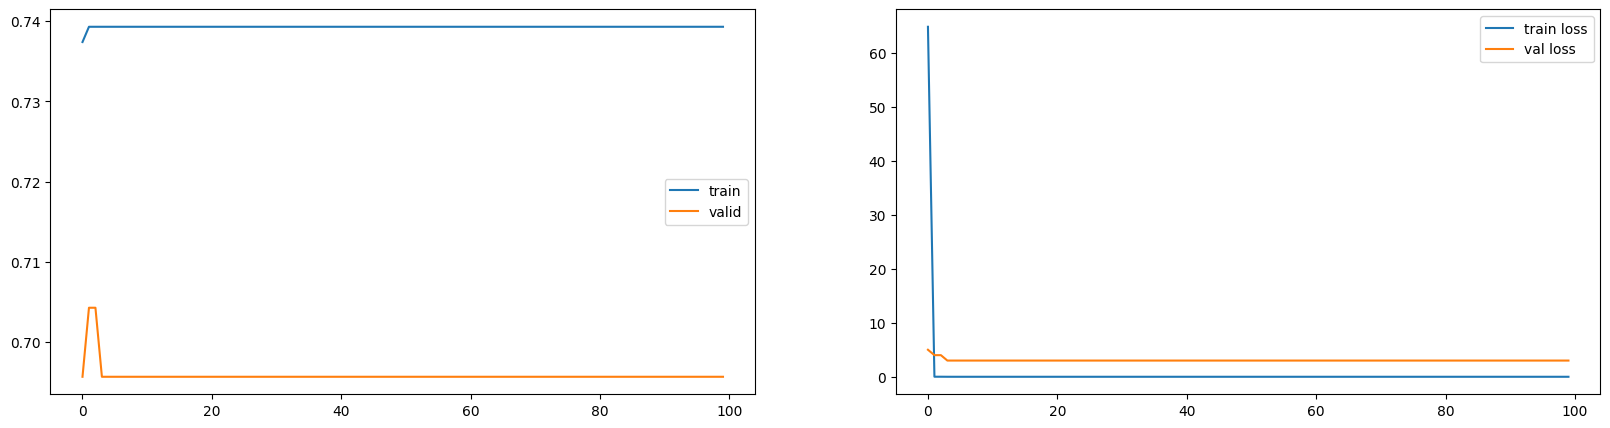

train accuracy: 0.7393 ,train f1score: 0.8066
val accuracy: 0.6957 ,val f1score: 0.7712

using: 0.001
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


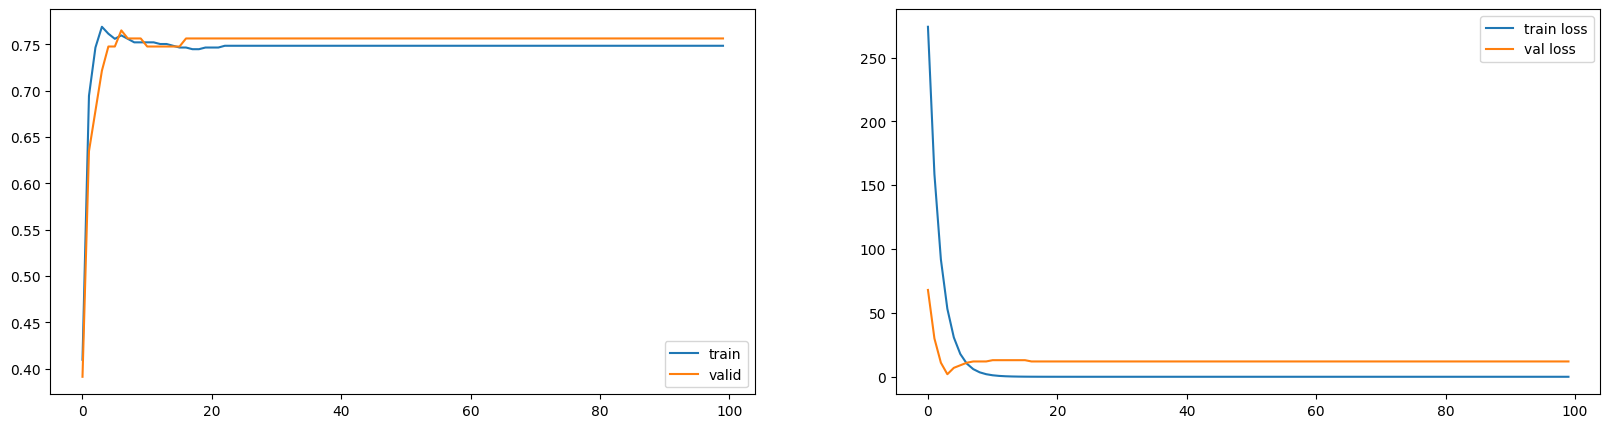

train accuracy: 0.7486 ,train f1score: 0.8173
val accuracy: 0.7565 ,val f1score: 0.8272

using: 0.0001
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


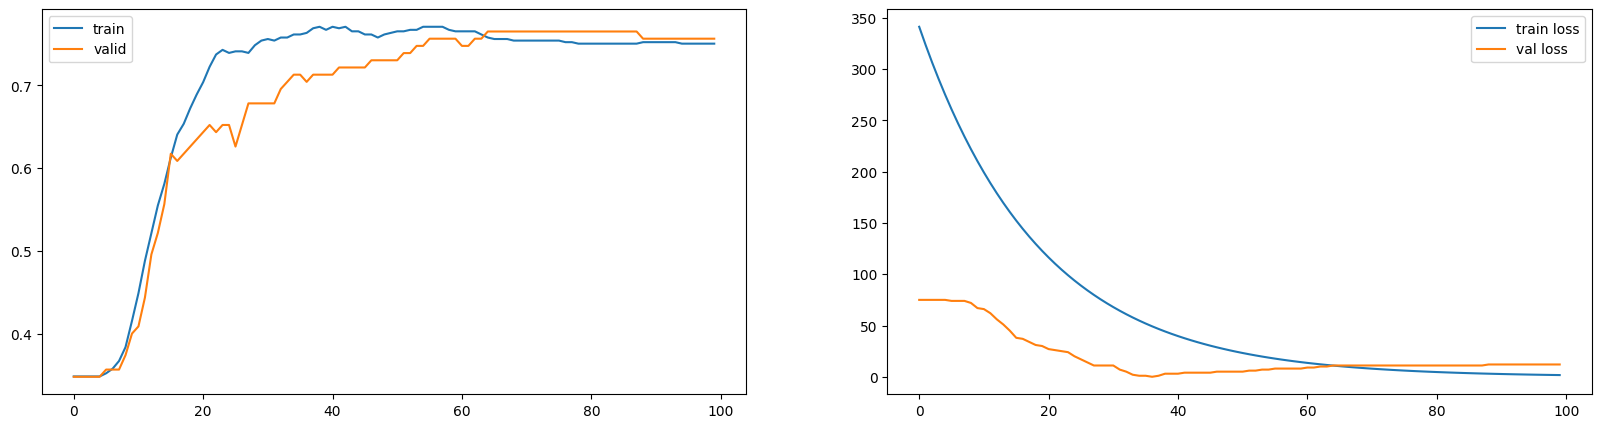

train accuracy: 0.7505 ,train f1score: 0.8199
val accuracy: 0.7565 ,val f1score: 0.8272

using: 1e-05
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


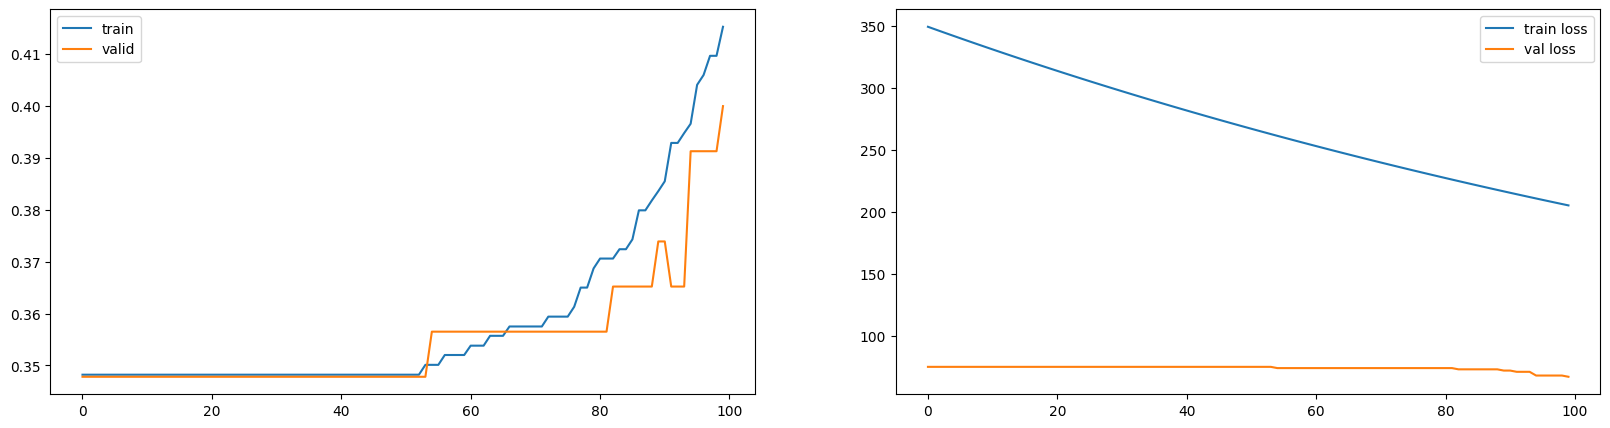

train accuracy: 0.4153 ,train f1score: 0.1907
val accuracy: 0.4 ,val f1score: 0.1687



In [451]:
##Test for lr
## Some learning rates lower than 0.1, as we have seen above using learning rates are not yielding good results
for learning_rate in [1e-2,1e-3,1e-4,1e-5]:
    print('using:',learning_rate)
    perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
    perceptron.train(epochs=100,lr=learning_rate,plot=True)
    perceptron.train_val()
    print()
## going with 0.0001 as it seeems the optimal one, not too high not too low

In [452]:
##Test for lr decay , since 0.001 and 0.0001 gave similar results testing with all
for lr in [0.001,0.0001]:
    for decay in [0,1e-1,1e-2,1e-3]:
        print('using lr:',lr,'and decay:',decay)
        perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
        perceptron.train(epochs=100,lr=lr,decay=decay)
        perceptron.train_val()
        print()

using lr: 0.001 and decay: 0
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7486 ,train f1score: 0.8173
val accuracy: 0.7565 ,val f1score: 0.8272

using lr: 0.001 and decay: 0.1
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7672 ,train f1score: 0.8252
val accuracy: 0.7217 ,val f1score: 0.7922

using lr: 0.001 and decay: 0.01
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7505 ,train f1score: 0.8194
val accuracy: 0.7478 ,val f1score: 0.8221

using lr: 0.001 and decay: 0.001
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) 

using lr: 0.001 and decay: 0
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


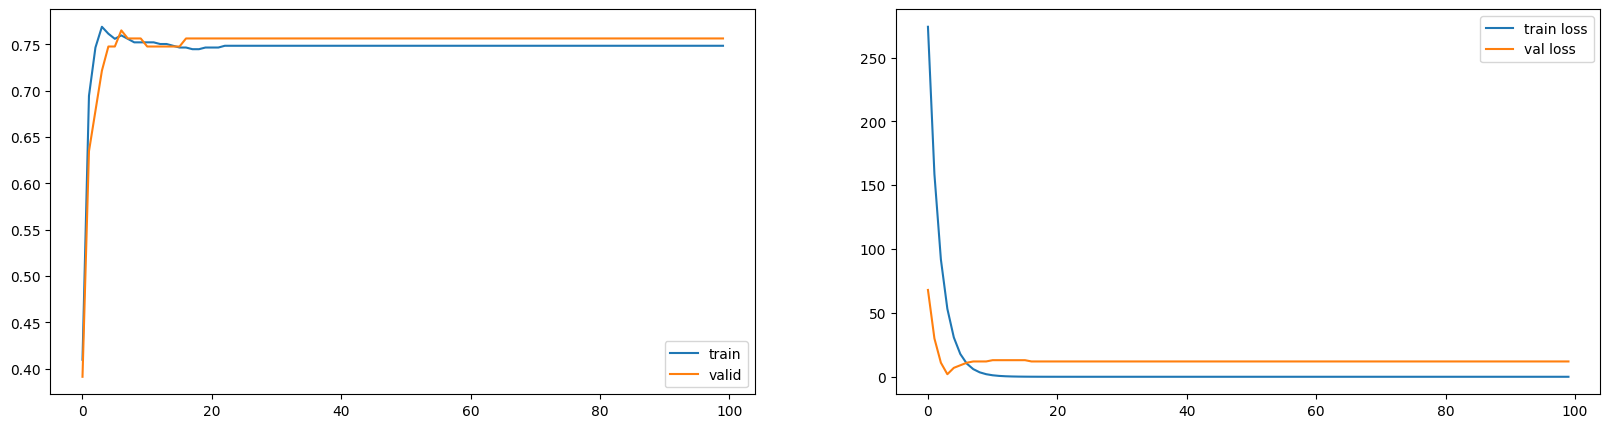

train accuracy: 0.7486 ,train f1score: 0.8173
val accuracy: 0.7565 ,val f1score: 0.8272

using lr: 0.001 and decay: 0.01
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


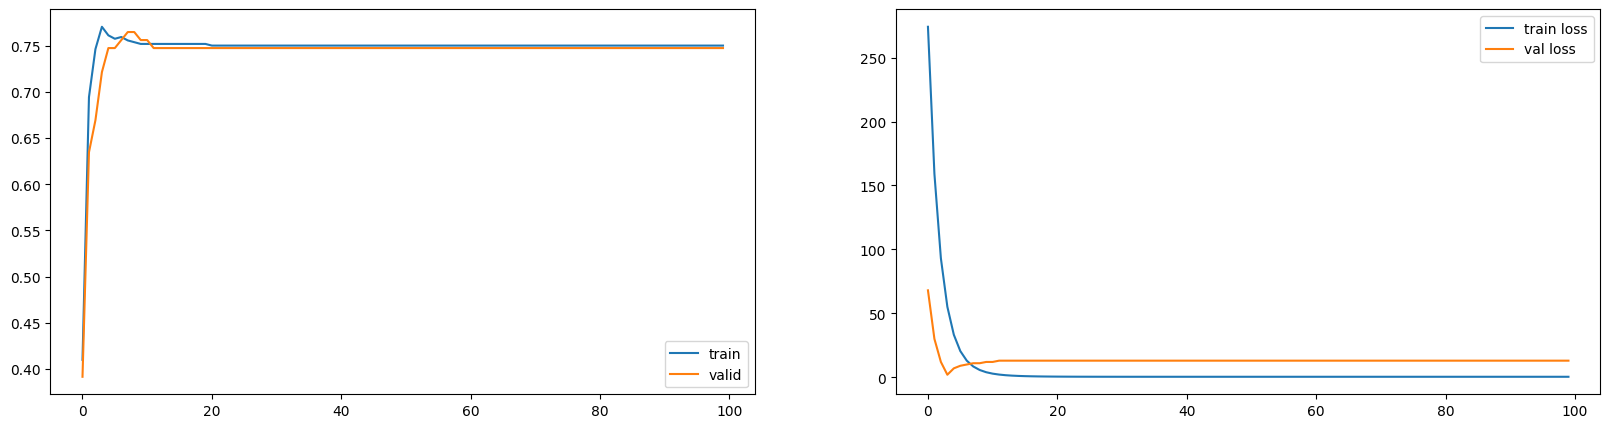

train accuracy: 0.7505 ,train f1score: 0.8194
val accuracy: 0.7478 ,val f1score: 0.8221

using lr: 0.001 and decay: 0.001
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


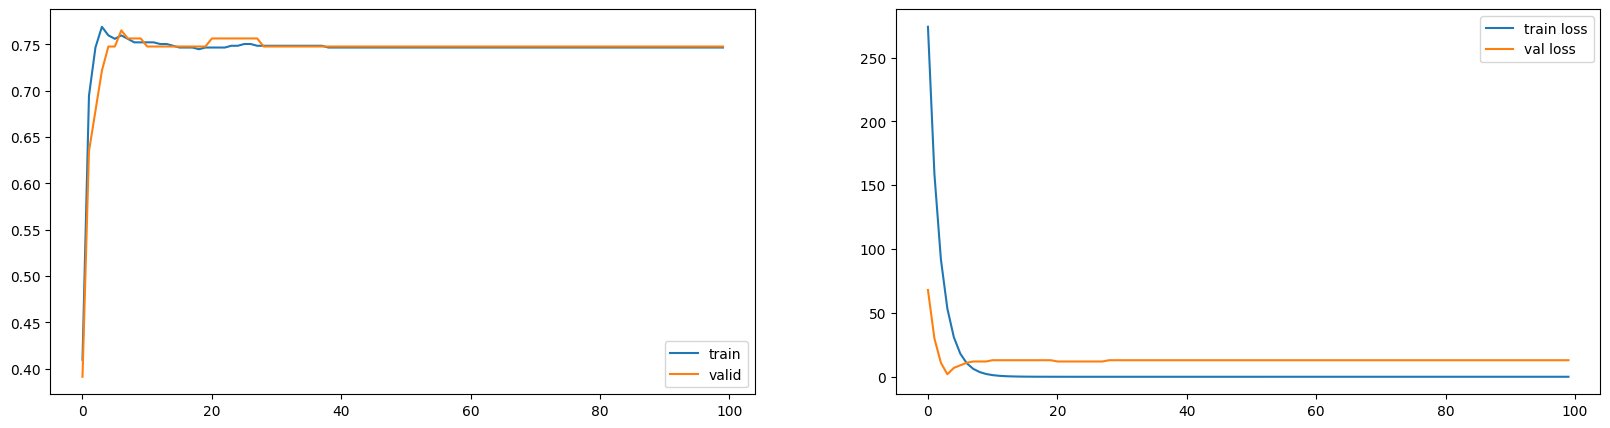

train accuracy: 0.7467 ,train f1score: 0.8157
val accuracy: 0.7478 ,val f1score: 0.8221

using lr: 0.0001 and decay: 0
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


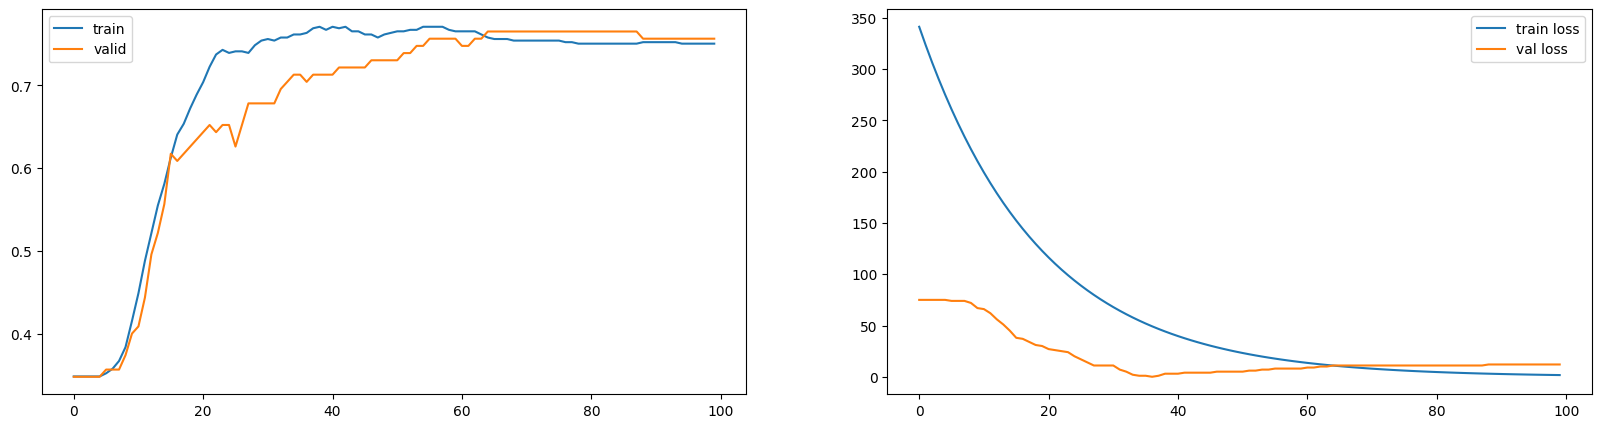

train accuracy: 0.7505 ,train f1score: 0.8199
val accuracy: 0.7565 ,val f1score: 0.8272



In [453]:
## selected the hyperparameters which had val f1 score above 80 and looking at the graphs to select the best hyperparameters
for parameter in [(0.001,0),(0.001,1e-2),(0.001,1e-3),(0.0001,0)]:
        lr,decay=parameter
        print('using lr:',lr,'and decay:',decay)
        perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
        perceptron.train(epochs=100,lr=lr,decay=decay,plot=True)
        perceptron.train_val()
        print()
## selecting 0.0001 as seen above and as seen in the below graphs it has gradual learning.

In [454]:
##Test for batchsize
## Some batchsize used generally
for batch in [4,8,16,32,64]:
    print('using:',batch)
    perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
    perceptron.train(lr=0.0001,batch_size=batch,epochs=100)
    perceptron.train_val()
    print()
## going with 4 as eventhough it is giving similar performance 4 has better overall.

using: 4
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7505 ,train f1score: 0.8199
val accuracy: 0.7565 ,val f1score: 0.8272

using: 8
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7356 ,train f1score: 0.8076
val accuracy: 0.7478 ,val f1score: 0.8176

using: 16
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7039 ,train f1score: 0.802
val accuracy: 0.6783 ,val f1score: 0.7861

using: 32
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train ac

**From the above experimental test, best model parameters are:**
* scaling: True
* scaler: Standard
* epochs=100
* lr=0.0001
* batch_size=4
* decay=0

the best model here has a 75.65% of val accuracy and 82.72% of f1 score.

we can compare and select the final model below, but I don't expect much difference as there isn't much difference in the selected hyperparameters

## Final Model

Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


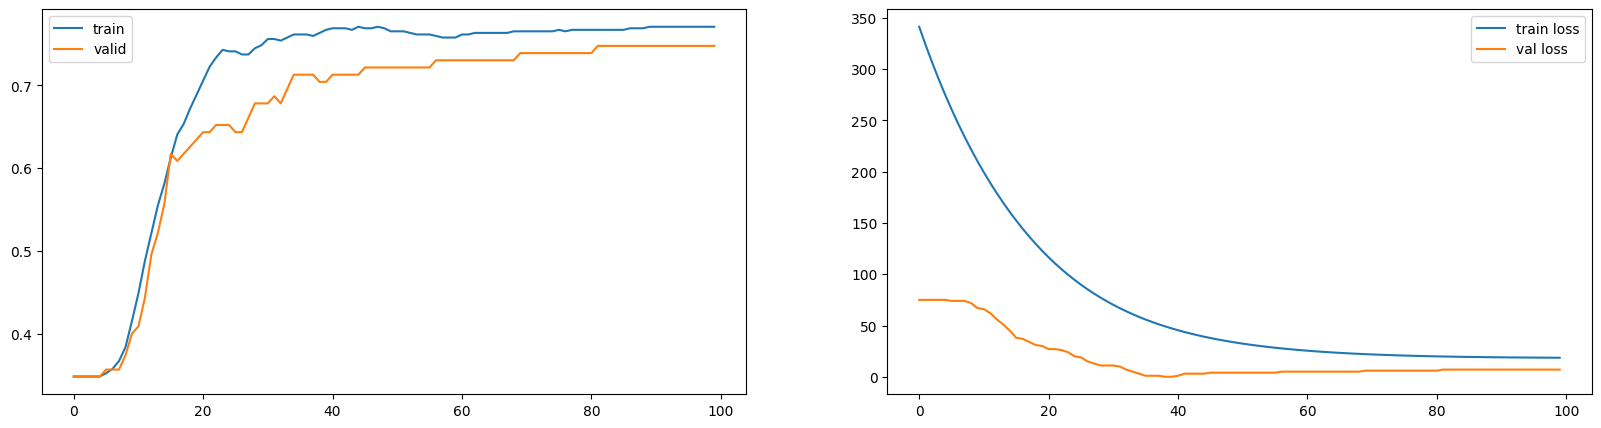

train accuracy: 0.7709 ,train f1score: 0.8317
val accuracy: 0.7478 ,val f1score: 0.8153


In [18]:
## Final model: evolution
perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
perceptron.train(lr=0.0001,plot=True,epochs=100,decay=0.001,decay_epoch=15)
perceptron.train_val()

Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


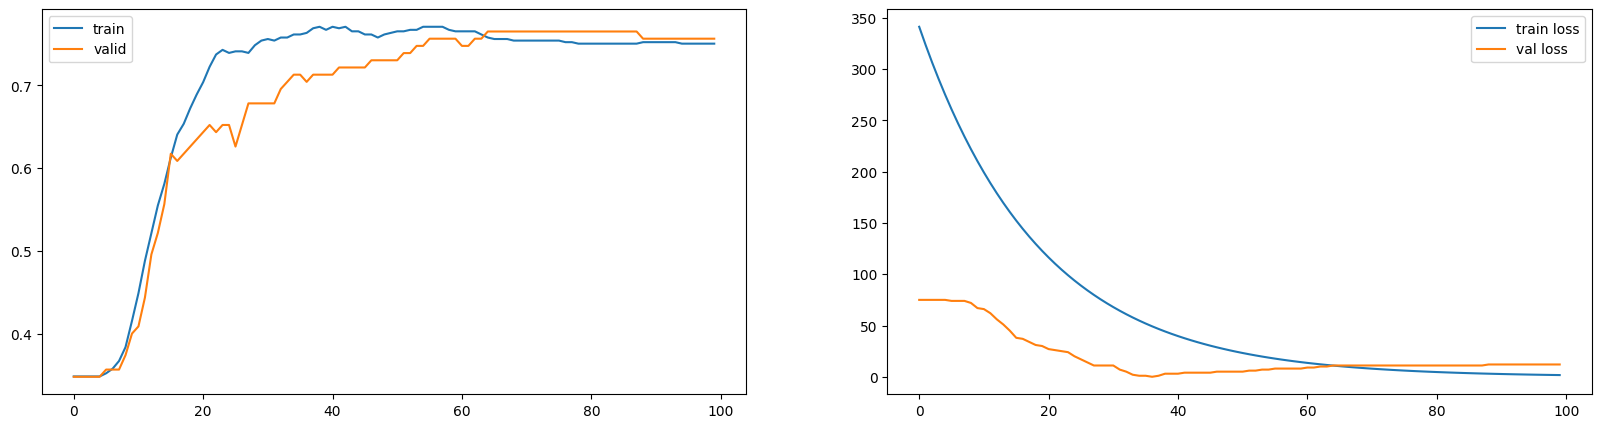

train accuracy: 0.7505 ,train f1score: 0.8199
val accuracy: 0.7565 ,val f1score: 0.8272


In [484]:
## Final Model: Hyperparameter tuning
perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
perceptron.train(lr=0.0001,plot=True,epochs=100,decay=0)
perceptron.train_val()

*** Going with the First Model as it has similar val performance, it has better train, and thus has converged to a better point ***

**From the above tests, best model parameters are:**
* scaling: True
* scaler: Standard Scaler
* epochs=100
* lr=0.0001
* decay=0.001
* decay epoch=40

with 74.78% of val accuracy and 81.53% of f1 score


## Testing Performance of the best Model

Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler


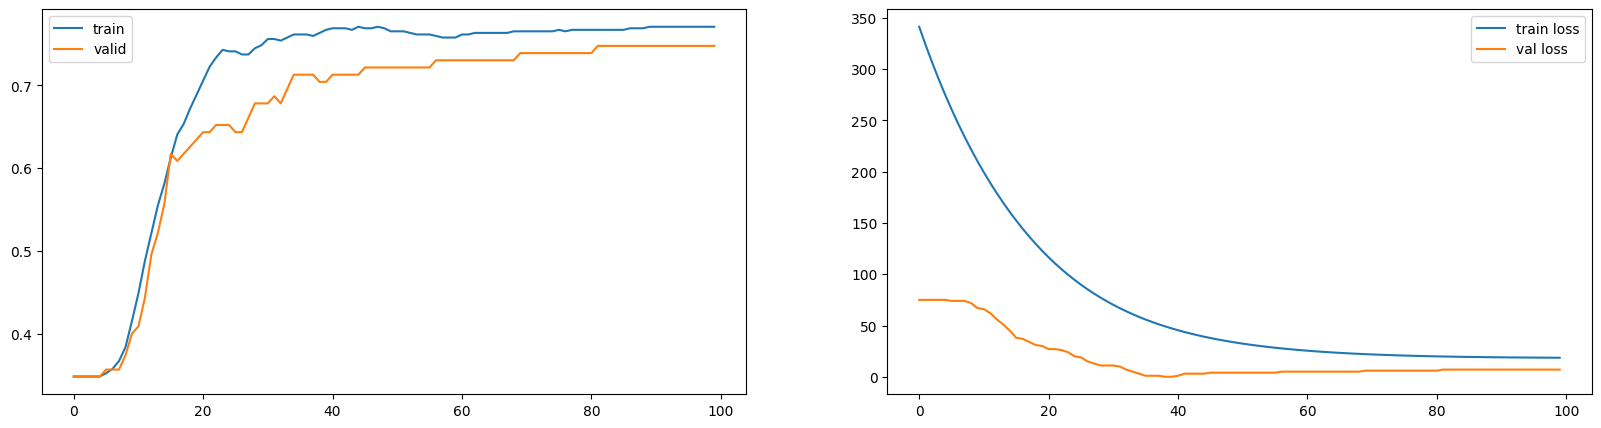

train accuracy: 0.7709 ,train f1score: 0.8317
val accuracy: 0.7478 ,val f1score: 0.8153
test accuracy: 0.8103 ,test f1score: 0.859


In [17]:
perceptron=Perceptron(X,y,scaling=True,scaler=sklearn.preprocessing.StandardScaler)
perceptron.train(lr=0.0001,plot=True,epochs=100,decay=0.001,decay_epoch=15)
perceptron.train_val()
perceptron.test()

***Final Model Parameters and Performance:***

*Best Model Parameters and Hyperparameters*
<br> </br>
| Parameter          | Value |
| :---------------- | :------: |
| Split        |   [0.7,0.15,0.15]  |
| Scaling           |   True   | 
| Scaler   |  StandardScaler   | 
| epochs           | 100     | 
| Batch size    |  4 |
| learning rate           |   0.0001   | 
| learning rate deacy   |  0.001   |
| decay start epoch         |   20  | 
| activation   |  None   |

<br></br>
| Dataset             | Accuracy | F1 Score |
| :---------------- | :------: | ----: |
| Train        |   76.54  | 82.83 |
| Validation           |   74.78   | 81.53 |
| Test    |  80.17   | 85.9 |
